本代码应用 movielens 的数据集，讲解如何利用深度学习构造推荐系统模型。推荐系统的目标函数有很多，比如推荐评分最高的，或者推荐点击率最高的等等。有时候我们还会兼顾推荐内容的多样性。我们在这里讲解的是最根本的基于用户给内容打分的情形。这里的核心思想是对用户和内容建模，从而预测用户对未看过内容的打分。推荐系统进而会把预测的高分内容呈现给用户。

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense, Reshape
from keras.layers.merge import Dot, Concatenate
from keras.models import Model, Input

Using CNTK backend


依常规，我们首先得进行探索性分析，看看数据集和评分分布长什么样子的。借此我们还要计算评分稀疏性，因为所有的推荐系统都是基于大量缺失数据的。在这里，我们的思路是预测整个评分表，把缺失数据还原。

[6040, 3952, 1000209]


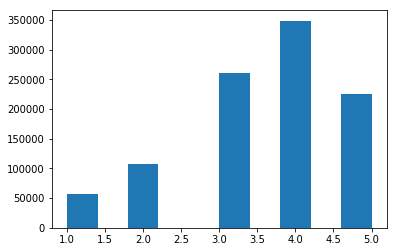

3.581564453029317


In [2]:
ratings = pd.read_csv('./data/ratings.dat', sep = '::', \
    engine='python',names = ['user_id','movie_id','rating','timestamp'])
n_users = np.max(ratings['user_id'])
n_movies = np.max(ratings['movie_id'])
print([n_users, n_movies, len(ratings)])

plt.hist(ratings['rating'])
plt.show()
print(np.mean(ratings['rating']))

接下来我们进行对**用户**和**内容**的建模，使用的是我们熟悉的 Emdbedding 思想。我们使用的 Embedding 维度为128。读者可以自行调整。

`Embedding`（嵌入层）是使用在模型第一层的一个网络层，其目的是将所有索引标号映射到紧致的低维向量中：

In [3]:
k = 128    
model1 = Sequential()
model1.add(Embedding(n_users + 1, k, input_length = 1))
model1.add(Reshape((k,)))
model2 = Sequential()
model2.add(Embedding(n_movies + 1, k, input_length = 1))
model2.add(Reshape((k,)))

In [4]:
model2.input, model2.output

(Input('embedding_2_input', [#], [1]),
 Composite(Reshape): Input('embedding_2_input', [#], [1]) -> Output('Reshape21_Output_0', [#], [128]))

我们的思路是通过计算用户和内容的向量乘积，得出评分。

In [5]:
model = Sequential()
m = Dot(axes=1)([model1.output, model2.output])
model_output = m
model = Model([model1.input, model2.input], model_output)
model.compile(loss = 'mse', optimizer = 'adam')
#model.compile(loss = 'mse', optimizer = 'rmsprop')
#model.compile(loss = 'mse', optimizer = 'adagrad')

准备好训练数据，代入模型。

In [6]:
users = ratings['user_id'].values
movies = ratings['movie_id'].values
X_train = [users, movies]
y_train = ratings['rating'].values

In [7]:
model.fit(X_train, y_train, batch_size = 500, epochs = 50)

Epoch 1/50
1000209/1000209 [==============================] - 29s 29us/step - loss: 4.2396
Epoch 2/50
1000209/1000209 [==============================] - 29s 29us/step - loss: 0.8231
Epoch 3/50
1000209/1000209 [==============================] - 29s 29us/step - loss: 0.7453
Epoch 4/50
1000209/1000209 [==============================] - 29s 29us/step - loss: 0.6807
Epoch 5/50
1000209/1000209 [==============================] - 29s 29us/step - loss: 0.6159
Epoch 6/50
1000209/1000209 [==============================] - 29s 29us/step - loss: 0.5457
Epoch 7/50
1000209/1000209 [==============================] - 29s 29us/step - loss: 0.4744
Epoch 8/50
1000209/1000209 [==============================] - 30s 30us/step - loss: 0.4080
Epoch 9/50
1000209/1000209 [==============================] - 30s 30us/step - loss: 0.3519
Epoch 10/50
1000209/1000209 [==============================] - 29s 29us/step - loss: 0.3076
Epoch 11/50
1000209/1000209 [==============================] - 30s 30us/step - loss: 0.27

我们看下模型预测效果。注意到我们这里作为演示，只做了模型拟合程度，读者可以把原始数据集分成训练，校对和测试数据集，评估模型准确率。我们这里看一个例子，预测第 `10` 号用户对第 `99` 号内容的打分。

In [8]:
i=10
j=99
pred = model.predict([np.array([users[i]]), np.array([movies[j]])])

In [9]:
print(pred)

[[ 2.25138307]]


我们计算模型在训练数据集上的均方差。这告诉我们拟合程度的好坏。

In [10]:
mse = model.evaluate(x=X_train, y = y_train, batch_size=128)
print(mse)

1000209/1000209 [==============================] - 23s 23us/step
0.0862701111813


我们接下来构建深度学习模型。这里的想法与上述稍微不同。我们把用户和内容的 Embedding 合并在一起（concatenate)，作为输入层，然后通过网络模型提取一层层特征，最后用线性变换得出预测评分。

In [11]:
k = 128
input_1 = Input(shape=(1,))
model1 = Embedding(n_users + 1, k, input_length = 1)(input_1)
model1 = Reshape((k,))(model1)
input_2 = Input(shape=(1,))
model2 = Embedding(n_movies + 1, k, input_length = 1)(input_2)
model2 = Reshape((k,))(model2)

In [12]:
input_1,input_2, model1,model2

(Input('input_1', [#], [1]),
 Input('input_2', [#], [1]),
 Composite(Reshape): Input('input_1', [#], [1]) -> Output('Reshape450_Output_0', [#], [128]),
 Composite(Reshape): Input('input_2', [#], [1]) -> Output('Reshape460_Output_0', [#], [128]))

In [13]:
model = Concatenate()([model1, model2])
model = Dropout(0.2)(model)
model = Dense(k, activation = 'relu')(model)
model = Dropout(0.5)(model)
model = Dense(int(k/4), activation = 'relu')(model)
model = Dropout(0.5)(model)
model = Dense(int(k/16), activation = 'relu')(model)
model = Dropout(0.5)(model)
yhat = Dense(1, activation = 'linear')(model)
model = Model([input_1, input_2], yhat)
model.compile(loss = 'mse', optimizer = "adam")

和之前一样，我们准备好训练数据集，代入模型训练。并通过均方差计算模型的拟合程度。

In [14]:
users = ratings['user_id'].values
movies = ratings['movie_id'].values
label = ratings['rating'].values
X_train = [users, movies]
y_train = label

In [15]:
model.fit(X_train, y_train, batch_size = 1000, epochs = 50)

Epoch 1/50
1000209/1000209 [==============================] - 20s 20us/step - loss: 3.8554
Epoch 2/50
1000209/1000209 [==============================] - 20s 20us/step - loss: 2.1430
Epoch 3/50
1000209/1000209 [==============================] - 20s 20us/step - loss: 1.4905
Epoch 4/50
1000209/1000209 [==============================] - 24s 24us/step - loss: 1.1942 0s - loss: 1.
Epoch 5/50
1000209/1000209 [==============================] - 22s 22us/step - loss: 1.0134
Epoch 6/50
1000209/1000209 [==============================] - 22s 22us/step - loss: 0.9326
Epoch 7/50
1000209/1000209 [==============================] - 20s 20us/step - loss: 0.9102
Epoch 8/50
1000209/1000209 [==============================] - 20s 20us/step - loss: 0.9028
Epoch 9/50
1000209/1000209 [==============================] - 20s 20us/step - loss: 0.8967
Epoch 10/50
1000209/1000209 [==============================] - 20s 20us/step - loss: 0.8925
Epoch 11/50
1000209/1000209 [==============================] - 21s 21us/ste

In [16]:
i,j = 10,99
pred = model.predict([np.array([users[i]]), np.array([movies[j]])])

mse = model.evaluate(x=X_train, y=y_train, batch_size=128)
print(mse)

1000209/1000209 [==============================] - 33s 33us/step
0.682069986752
